## 誘導式深度學習 (Highlighted DL) 效果在 TensorFlow + Keras 上的實證

### 實驗背景
　　這是基於我的碩士論文「以誘導式深度學習為基礎之配藥核實技術及應用」所延伸的實驗（多國發明專利申請中，論文未公開）。在原始論文裡，我採用了 YOLO v2、ResNet 與 SE-ResNet 三種網路，證明「誘導式深度學習」能有效解決**訓練樣本稀少**、**藥物外觀相似**與**藥物種類繁多**等藥物識別上的難題，不但將藥物辨識率從 86% 提升至 99.8%，更採用 NVIDIA® Jetson TX2 嵌入式系統與模型結構優化技術，實現 6.23 幀 / 秒的實時藥物識別產品雛型。

　　由於 YOLO v2、ResNet 與 SE-ResNet 皆屬較龐大的網路，所以，為了證明「誘導式深度學習」在簡單的 CNN 網路上**也能有卓越的識別率優化效果**，我將使用論文中未出現的 TensorFlow 與 Keras 框架重新進行實驗，也就是接下來這份文件中的內容。


### 數據說明
　　這項實驗所採用的數據與原始論文相同：成人錠劑**排藥包裝 (Blister Package)** 共 250 類，每個類別正、反面各 72 張，總計 36,000 張影像。對了！這是一份公開數據集，您可以在 [Google Drive](https://drive.google.com/folderview?id=1cV7JVYGRxcm9DY0o7BMJHTCRdo_RW17n) 或 [Baidu Pan](https://pan.baidu.com/s/1amfARVIhGIfYVIIfB9qFRg) 下載，供學術研究與非商業性質的實驗使用。


### 實驗說明
　　與原始論文相同，我將使用排藥的 **1. 正面原始影像**、**2. 背面原始影像**，與經過「誘導式深度學習」技術生成的 **3. 雙面拼整影像**資料集，對相同的 CNN 網路進行訓練與測試，目的在於觀察「誘導式深度學習」技術的採用與否，對排藥識別效果的影響會有多大。
  
　　在訓練樣本、測試樣本的分配上，將依照 3:1 的比例，對每類別 72 張圖像**隨機抽取** 54 張作為訓練集 (Training-set)、18 張作為測試集 (Testing-set)，總計訓練樣本 13,500 張，訓練樣本外 (Out-of-sample) 的測試樣本 4,500 張。訓練時，還會從每類別 54 張訓練圖像中再**隨機抽取** 18 張作為驗證集 (Validation-set)。
  
　　介紹完了，我們開始吧！

---

## Step 1. 環境參數設定
設置載入的套件與資料集路徑。在本實驗中，我將採用 150 x 150 的圖像輸入尺寸進行模型的訓練與測試，而非原始論文的 224 x 224。

In [1]:
import os, shutil
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.layers.core import Dropout
import matplotlib.pyplot as plt
import numpy as np

image_size = 150

# 正面原始影像的訓練與測試圖像路徑。
front_train_dir = "/home/ubuntu/Desktop/High/OriginalFrontTrain"
front_test_dir = "/home/ubuntu/Desktop/High/OriginalFrontTest"

# 背面原始影像的訓練與測試圖像路徑。
back_train_dir = "/home/ubuntu/Desktop/High/OriginalBackTrain"
back_test_dir = "/home/ubuntu/Desktop/High/OriginalBackTest"

# 雙面拼整影像的訓練與測試圖像路徑。
high_train_dir = "/home/ubuntu/Desktop/High/HighlightedTrain"
high_test_dir = "/home/ubuntu/Desktop/High/HighlightedTest"

Using TensorFlow backend.


## Step 2. 建立簡單的 CNN 模型（三種資料集都使用相同的模型結構）
卷積神經網路中採用 Dropout 防止數據過擬合；最後一個全連接層使用 Softmax 作為激活函數，對 250 種排藥類別進行預測。

In [2]:
# 訓練與識別正面原始影像的模型
model_front = models.Sequential()
model_front.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))

model_front.add(layers.Flatten())
model_front.add(layers.Dense(128, activation = 'relu'))
model_front.add(Dropout(0.5))
model_front.add(layers.Dense(250, activation = 'softmax'))


# 訓練與識別背面原始影像的模型
model_back = models.Sequential()
model_back.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))

model_back.add(layers.Flatten())
model_back.add(layers.Dense(128, activation = 'relu'))
model_back.add(Dropout(0.5))
model_back.add(layers.Dense(250, activation = 'softmax'))


# 訓練與識別雙面拼整影像的模型
model_high = models.Sequential()
model_high.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))

model_high.add(layers.Flatten())
model_high.add(layers.Dense(128, activation = 'relu'))
model_high.add(Dropout(0.5))
model_high.add(layers.Dense(250, activation = 'softmax'))


# 看看模型長什麼樣子
model_high.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        18496     
__________

## Step 3. 編譯模型
使用 'categorical_crossentropy' 作為損失函數，讓「網路輸出」的機率分佈與「真實標籤」的分佈盡可能一致。

In [3]:
model_front.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model_back.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model_high.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

## Step 4. 採用 Generator 批量生成訓練與驗證資料
使用驗證資料集來確認該在何時執行 Early Stopping，以便稍後（Step 8）選用最佳模型進行測試資料集的效果評估。

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# 從同一個 training 資料路徑下拆分出 training 與 validation 的數據集。
# 設定 validation_split=0.35，從每類 54 張訓練樣本中抽取 18 張作為驗證樣本。

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.35)

# 正面原始影像的 Generator

print("Status of front images:")

print("[Training set]")

front_train_gen = data_generator.flow_from_directory(
        front_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical', # 多類別，所以使用 categorical 標籤，返回 2D 的 one-hot 編碼標籤。
        batch_size = 36,
        subset = "training") # 因為啟用了 validation_split，故可設定 train_generator 放的是「訓練子集」。

print("[Validation set]")

front_validation_gen = data_generator.flow_from_directory(
        front_train_dir, # 一樣從 training 的路徑下抓取驗證用數據。
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "validation") # 因為啟用了 validation_split，故可設定 validation_generator 放的是「驗證子集」。

# 背面原始影像的 Generator

print("\nStatus of back images:")

print("[Training set]")

back_train_gen = data_generator.flow_from_directory(
        back_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "training")

print("[Validation set]")

back_validation_gen = data_generator.flow_from_directory(
        back_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "validation")

# 雙面拼整影像的 Generator

print("\nStatus of highlighted images:")

print("[Training set]")

high_train_gen = data_generator.flow_from_directory(
        high_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "training")

print("[Validation set]")

high_validation_gen = data_generator.flow_from_directory(
        high_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36,
        subset = "validation")

Status of front images:
[Training set]
Found 9000 images belonging to 250 classes.
[Validation set]
Found 4500 images belonging to 250 classes.

Status of back images:
[Training set]
Found 9000 images belonging to 250 classes.
[Validation set]
Found 4500 images belonging to 250 classes.

Status of highlighted images:
[Training set]
Found 9000 images belonging to 250 classes.
[Validation set]
Found 4500 images belonging to 250 classes.


## Step 5. 定義 Callback Function 以計算 Percision / Recall / F1-Score
Keras 提供的...只能在xxx計算一次，不是每個 Epoch。此外，Generator 若要使用 Callback 函式，需有特別的設計方法。

### 參考資料
* https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
* https://github.com/keras-team/keras/issues/10472#issuecomment-472543538

In [5]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import warnings
import sklearn.exceptions

warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# 紀錄每個 Epoch 訓練結束時，使用驗證集測試得到的 F1-score 結果
front_f1s = []
back_f1s = []
high_f1s = []

class MetricsFront(Callback):

    def __init__(self, val_data = front_validation_gen, batch_size = 36):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total, 250))
        val_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yVal
            
        val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average = 'micro')
        _val_precision = precision_score(val_true, val_pred, average = 'micro')
        _val_recall = recall_score(val_true, val_pred, average = 'micro')
        
        front_f1s.append(_val_f1)

        print("- val_f1: %f - val_precision: %f - val_recall: %f"%(_val_f1, _val_precision, _val_recall))
        return
    
class MetricsBack(Callback):

    def __init__(self, val_data = back_validation_gen, batch_size = 36):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total, 250))
        val_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yVal
            
        val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average = 'micro')
        _val_precision = precision_score(val_true, val_pred, average = 'micro')
        _val_recall = recall_score(val_true, val_pred, average = 'micro')
        
        back_f1s.append(_val_f1)
        
        print("- val_f1: %f - val_precision: %f - val_recall: %f"%(_val_f1, _val_precision, _val_recall))
        return
    
class MetricsHigh(Callback):

    def __init__(self, val_data = high_validation_gen, batch_size = 36):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs={}):
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total, 250))
        val_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xVal)).round()
            val_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yVal
            
        val_pred = np.squeeze(val_pred)
        _val_f1 = f1_score(val_true, val_pred, average = 'micro')
        _val_precision = precision_score(val_true, val_pred, average = 'micro')
        _val_recall = recall_score(val_true, val_pred, average = 'micro')
        
        high_f1s.append(_val_f1)
        
        print("- val_f1: %f - val_precision: %f - val_recall: %f"%(_val_f1, _val_precision, _val_recall))
        return

## Step 6. 訓練與驗證深度學習網路

In [6]:
print("Front images training:")

model_front.fit_generator(
    front_train_gen,
    steps_per_epoch = 250,
    epochs = 100,
    validation_data = front_validation_gen,
    validation_steps = 125,
    callbacks = [MetricsFront()])

print("\nBack images training:")

model_back.fit_generator(
    back_train_gen,
    steps_per_epoch = 250,
    epochs = 100,
    validation_data = back_validation_gen,
    validation_steps = 125,
    callbacks = [MetricsBack()])

print("\nHighlighted images training:")

model_high.fit_generator(
    high_train_gen,
    steps_per_epoch = 250,
    epochs = 100,
    validation_data = high_validation_gen,
    validation_steps = 125,
    callbacks = [MetricsHigh()])

Front images training:
Epoch 1/100
250/250 [==============================] - 138s 552ms/step - loss: 5.4070 - acc: 0.0066 - val_loss: 5.2364 - val_acc: 0.0091
- val_f1: 0.000000 - val_precision: 0.000000 - val_recall: 0.000000
Epoch 2/100
250/250 [==============================] - 121s 486ms/step - loss: 4.9640 - acc: 0.0217 - val_loss: 4.5970 - val_acc: 0.0587
- val_f1: 0.000000 - val_precision: 0.000000 - val_recall: 0.000000
Epoch 3/100
250/250 [==============================] - 121s 485ms/step - loss: 4.4790 - acc: 0.0546 - val_loss: 4.2231 - val_acc: 0.0931
- val_f1: 0.009288 - val_precision: 0.954545 - val_recall: 0.004667
Epoch 4/100
250/250 [==============================] - 121s 486ms/step - loss: 4.0550 - acc: 0.0906 - val_loss: 3.7718 - val_acc: 0.1698
- val_f1: 0.017613 - val_precision: 0.952381 - val_recall: 0.008889
Epoch 5/100
250/250 [==============================] - 122s 486ms/step - loss: 3.6821 - acc: 0.1318 - val_loss: 3.5351 - val_acc: 0.2238
- val_f1: 0.047629 -

250/250 [==============================] - 121s 485ms/step - loss: 1.1365 - acc: 0.6641 - val_loss: 1.8218 - val_acc: 0.5120
- val_f1: 0.510385 - val_precision: 0.677076 - val_recall: 0.409556
Epoch 42/100
250/250 [==============================] - 121s 485ms/step - loss: 1.1480 - acc: 0.6631 - val_loss: 1.1511 - val_acc: 0.6718
- val_f1: 0.653492 - val_precision: 0.835873 - val_recall: 0.536444
Epoch 43/100
250/250 [==============================] - 121s 484ms/step - loss: 1.1115 - acc: 0.6677 - val_loss: 1.5718 - val_acc: 0.5756
- val_f1: 0.579867 - val_precision: 0.742798 - val_recall: 0.475556
Epoch 44/100
250/250 [==============================] - 121s 485ms/step - loss: 1.0668 - acc: 0.6822 - val_loss: 1.2976 - val_acc: 0.6273
- val_f1: 0.611813 - val_precision: 0.801079 - val_recall: 0.494889
Epoch 45/100
250/250 [==============================] - 121s 486ms/step - loss: 1.0833 - acc: 0.6770 - val_loss: 1.5273 - val_acc: 0.5747
- val_f1: 0.574511 - val_precision: 0.716849 - val_

250/250 [==============================] - 122s 488ms/step - loss: 1.0932 - acc: 0.7023 - val_loss: 1.6022 - val_acc: 0.6193
- val_f1: 0.611929 - val_precision: 0.730129 - val_recall: 0.526667
Epoch 82/100
250/250 [==============================] - 122s 488ms/step - loss: 1.0928 - acc: 0.6989 - val_loss: 1.9424 - val_acc: 0.5198
- val_f1: 0.482827 - val_precision: 0.658602 - val_recall: 0.381111
Epoch 83/100
250/250 [==============================] - 122s 488ms/step - loss: 1.1436 - acc: 0.6894 - val_loss: 2.1243 - val_acc: 0.4584
- val_f1: 0.434301 - val_precision: 0.664986 - val_recall: 0.322444
Epoch 84/100
250/250 [==============================] - 122s 488ms/step - loss: 1.1259 - acc: 0.7010 - val_loss: 2.0652 - val_acc: 0.5056
- val_f1: 0.477939 - val_precision: 0.664687 - val_recall: 0.373111
Epoch 85/100
250/250 [==============================] - 122s 490ms/step - loss: 1.0880 - acc: 0.7094 - val_loss: 2.3818 - val_acc: 0.4513
- val_f1: 0.426471 - val_precision: 0.586314 - val_

250/250 [==============================] - 129s 516ms/step - loss: 1.3399 - acc: 0.6042 - val_loss: 1.2215 - val_acc: 0.6511
- val_f1: 0.594336 - val_precision: 0.857862 - val_recall: 0.454667
Epoch 22/100
250/250 [==============================] - 129s 517ms/step - loss: 1.3098 - acc: 0.6143 - val_loss: 1.0336 - val_acc: 0.7069
- val_f1: 0.656092 - val_precision: 0.890625 - val_recall: 0.519333
Epoch 23/100
250/250 [==============================] - 129s 517ms/step - loss: 1.2229 - acc: 0.6349 - val_loss: 1.0019 - val_acc: 0.7060
- val_f1: 0.687368 - val_precision: 0.847784 - val_recall: 0.578000
Epoch 24/100
250/250 [==============================] - 129s 516ms/step - loss: 1.1996 - acc: 0.6369 - val_loss: 1.0457 - val_acc: 0.6824
- val_f1: 0.662843 - val_precision: 0.828886 - val_recall: 0.552222
Epoch 25/100
250/250 [==============================] - 130s 518ms/step - loss: 1.1794 - acc: 0.6498 - val_loss: 1.0768 - val_acc: 0.6856
- val_f1: 0.644697 - val_precision: 0.855253 - val_

250/250 [==============================] - 129s 517ms/step - loss: 0.8019 - acc: 0.7763 - val_loss: 0.7188 - val_acc: 0.7902
- val_f1: 0.780034 - val_precision: 0.867719 - val_recall: 0.708444
Epoch 62/100
250/250 [==============================] - 129s 517ms/step - loss: 0.7628 - acc: 0.7824 - val_loss: 0.9079 - val_acc: 0.7398
- val_f1: 0.728894 - val_precision: 0.838439 - val_recall: 0.644667
Epoch 63/100
250/250 [==============================] - 129s 516ms/step - loss: 0.7472 - acc: 0.7837 - val_loss: 1.0154 - val_acc: 0.7280
- val_f1: 0.724691 - val_precision: 0.806759 - val_recall: 0.657778
Epoch 64/100
250/250 [==============================] - 129s 516ms/step - loss: 0.8032 - acc: 0.7779 - val_loss: 0.8105 - val_acc: 0.7744
- val_f1: 0.751558 - val_precision: 0.878905 - val_recall: 0.656444
Epoch 65/100
250/250 [==============================] - 129s 518ms/step - loss: 0.7820 - acc: 0.7870 - val_loss: 0.9883 - val_acc: 0.7404
- val_f1: 0.737494 - val_precision: 0.812901 - val_

Epoch 1/100
250/250 [==============================] - 110s 441ms/step - loss: 5.3054 - acc: 0.0143 - val_loss: 4.8838 - val_acc: 0.0580
- val_f1: 0.003106 - val_precision: 1.000000 - val_recall: 0.001556
Epoch 2/100
250/250 [==============================] - 99s 398ms/step - loss: 4.2503 - acc: 0.0879 - val_loss: 3.3262 - val_acc: 0.2798
- val_f1: 0.095601 - val_precision: 0.991228 - val_recall: 0.050222
Epoch 3/100
250/250 [==============================] - 99s 397ms/step - loss: 3.1674 - acc: 0.2309 - val_loss: 2.2947 - val_acc: 0.4911
- val_f1: 0.315613 - val_precision: 0.964773 - val_recall: 0.188667
Epoch 4/100
250/250 [==============================] - 99s 396ms/step - loss: 2.4528 - acc: 0.3623 - val_loss: 1.6300 - val_acc: 0.6631
- val_f1: 0.504274 - val_precision: 0.968434 - val_recall: 0.340889
Epoch 5/100
250/250 [==============================] - 99s 396ms/step - loss: 1.9382 - acc: 0.4802 - val_loss: 1.1117 - val_acc: 0.7662
- val_f1: 0.660623 - val_precision: 0.965797 - 

250/250 [==============================] - 99s 397ms/step - loss: 0.2225 - acc: 0.9378 - val_loss: 0.1210 - val_acc: 0.9724
- val_f1: 0.973039 - val_precision: 0.975648 - val_recall: 0.970444
Epoch 42/100
250/250 [==============================] - 99s 397ms/step - loss: 0.2182 - acc: 0.9381 - val_loss: 0.4087 - val_acc: 0.9156
- val_f1: 0.921547 - val_precision: 0.926933 - val_recall: 0.916222
Epoch 43/100
250/250 [==============================] - 99s 397ms/step - loss: 0.1971 - acc: 0.9446 - val_loss: 0.2343 - val_acc: 0.9540
- val_f1: 0.954788 - val_precision: 0.956920 - val_recall: 0.952667
Epoch 44/100
250/250 [==============================] - 99s 396ms/step - loss: 0.2100 - acc: 0.9417 - val_loss: 0.4618 - val_acc: 0.9078
- val_f1: 0.911571 - val_precision: 0.917210 - val_recall: 0.906000
Epoch 45/100
250/250 [==============================] - 100s 399ms/step - loss: 0.2062 - acc: 0.9429 - val_loss: 0.1734 - val_acc: 0.9647
- val_f1: 0.965217 - val_precision: 0.968456 - val_reca

250/250 [==============================] - 99s 396ms/step - loss: 0.2364 - acc: 0.9494 - val_loss: 0.4783 - val_acc: 0.9431
- val_f1: 0.944420 - val_precision: 0.944840 - val_recall: 0.944000
Epoch 82/100
250/250 [==============================] - 99s 395ms/step - loss: 0.2381 - acc: 0.9493 - val_loss: 0.3047 - val_acc: 0.9487
- val_f1: 0.951689 - val_precision: 0.957902 - val_recall: 0.945556
Epoch 83/100
250/250 [==============================] - 99s 396ms/step - loss: 0.2520 - acc: 0.9433 - val_loss: 0.1758 - val_acc: 0.9716
- val_f1: 0.968726 - val_precision: 0.970346 - val_recall: 0.967111
Epoch 84/100
250/250 [==============================] - 99s 396ms/step - loss: 0.2336 - acc: 0.9528 - val_loss: 0.0956 - val_acc: 0.9864
- val_f1: 0.985662 - val_precision: 0.985991 - val_recall: 0.985333
Epoch 85/100
250/250 [==============================] - 99s 396ms/step - loss: 0.2482 - acc: 0.9458 - val_loss: 0.9307 - val_acc: 0.8916
- val_f1: 0.892798 - val_precision: 0.894490 - val_recal

## Step 7. 尋找最佳模型並繪製 F1 Score 趨勢圖 

[Front]		42 epochs reach the best f1-score value 65.35%
[Back]		67 epochs reach the best f1-score value 79.88%
[Highlighted]	86 epochs reach the best f1-score value 98.71%


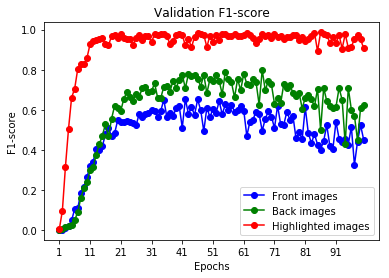

<Figure size 432x288 with 0 Axes>

In [7]:
best_front_epochs = front_f1s.index(max(front_f1s)) + 1
best_back_epochs = back_f1s.index(max(back_f1s)) + 1
best_high_epochs = high_f1s.index(max(high_f1s)) + 1

print("[Front]\t\t%d epochs reach the best f1-score value %.2f%%"%(best_front_epochs, max(front_f1s) * 100))
print("[Back]\t\t%d epochs reach the best f1-score value %.2f%%"%(best_back_epochs, max(back_f1s) * 100))
print("[Highlighted]\t%d epochs reach the best f1-score value %.2f%%"%(best_high_epochs, max(high_f1s) * 100))

plt.plot(range(100), front_f1s, 'b-o', label = 'Front images')
plt.plot(range(100), back_f1s, 'g-o', label = 'Back images')
plt.plot(range(100), high_f1s, 'r-o', label = 'Highlighted images')
plt.legend()
plt.title('Validation F1-score')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 100, step = 10), range(1, 101, 10))
plt.ylabel('F1-score')
plt.figure()

plt.show()

## Step 8. 使用完整資料重新訓練模型

In [8]:
# 重新建立卷積神經網路
model_front = models.Sequential()
model_front.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_front.add(layers.MaxPooling2D((2, 2)))
model_front.add(Dropout(0.25))
model_front.add(layers.Flatten())
model_front.add(layers.Dense(128, activation = 'relu'))
model_front.add(Dropout(0.5))
model_front.add(layers.Dense(250, activation = 'softmax'))

model_back = models.Sequential()
model_back.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_back.add(layers.MaxPooling2D((2, 2)))
model_back.add(Dropout(0.25))
model_back.add(layers.Flatten())
model_back.add(layers.Dense(128, activation = 'relu'))
model_back.add(Dropout(0.5))
model_back.add(layers.Dense(250, activation = 'softmax'))

model_high = models.Sequential()
model_high.add(layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_high.add(layers.MaxPooling2D((2, 2)))
model_high.add(Dropout(0.25))
model_high.add(layers.Flatten())
model_high.add(layers.Dense(128, activation = 'relu'))
model_high.add(Dropout(0.5))
model_high.add(layers.Dense(250, activation = 'softmax'))

# 重新編譯模型
model_front.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

model_back.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

model_high.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# 重新製作數據 Generator
data_generator = ImageDataGenerator(rescale=1./255)

print("Status of front images:")

print("[Training set]")

front_train_gen = data_generator.flow_from_directory(
        front_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("[Testing set]")

front_test_gen = data_generator.flow_from_directory(
        front_test_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("\nStatus of back images:")

print("[Training set]")

back_train_gen = data_generator.flow_from_directory(
        back_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("[Testing set]")

back_test_gen = data_generator.flow_from_directory(
        back_test_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("\nStatus of highlighted images:")

print("[Training set]")

high_train_gen = data_generator.flow_from_directory(
        high_train_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

print("[Testing set]")

high_test_gen = data_generator.flow_from_directory(
        high_test_dir,
        target_size = (image_size, image_size),
        shuffle = True,
        seed = 13,
        class_mode = 'categorical',
        batch_size = 36)

# 設定 Callback 函式並在訓練完成時，計算測試資料集的 F1-score
test_f1s = []

class MetricsFront(Callback):

    def __init__(self, test_data = front_test_gen, batch_size = 36):
        super().__init__()
        self.test_data = test_data
        self.batch_size = batch_size
        
    def on_train_end(self, epoch, logs={}):
        batches = len(self.test_data)
        total = batches * self.batch_size
        
        test_pred = np.zeros((total, 250))
        test_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xTest, yTest = next(self.test_data)
            test_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xTest)).round()
            test_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yTest
            
        test_pred = np.squeeze(test_pred)
        _test_f1 = f1_score(test_true, test_pred, average = 'micro')
        test_f1s.append(_test_f1)
        
        return
    
class MetricsBack(Callback):

    def __init__(self, test_data = back_test_gen, batch_size = 36):
        super().__init__()
        self.test_data = test_data
        self.batch_size = batch_size
        
    def on_train_end(self, epoch, logs={}):
        batches = len(self.test_data)
        total = batches * self.batch_size
        
        test_pred = np.zeros((total, 250))
        test_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xTest, yTest = next(self.test_data)
            test_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xTest)).round()
            test_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yTest
            
        test_pred = np.squeeze(test_pred)
        _test_f1 = f1_score(test_true, test_pred, average = 'micro')
        test_f1s.append(_test_f1)
        
        return
    
class MetricsHigh(Callback):

    def __init__(self, test_data = high_test_gen, batch_size = 36):
        super().__init__()
        self.test_data = test_data
        self.batch_size = batch_size
        
    def on_train_end(self, epoch, logs={}):
        batches = len(self.test_data)
        total = batches * self.batch_size
        
        test_pred = np.zeros((total, 250))
        test_true = np.zeros((total, 250))
        
        for batch in range(batches):
            xTest, yTest = next(self.test_data)
            test_pred[batch * self.batch_size : (batch + 1) * self.batch_size] = np.asarray(self.model.predict(xTest)).round()
            test_true[batch * self.batch_size : (batch + 1) * self.batch_size] = yTest
            
        test_pred = np.squeeze(test_pred)
        _test_f1 = f1_score(test_true, test_pred, average = 'micro')
        test_f1s.append(_test_f1)

        return
    
# 重新訓練深度學習網路
print("\nFront images training:")

model_front.fit_generator(
    front_train_gen,
    steps_per_epoch = 375,
    epochs = best_front_epochs,
    callbacks = [MetricsFront()])

print("\nBack images training:")

model_back.fit_generator(
    back_train_gen,
    steps_per_epoch = 375,
    epochs = best_back_epochs,
    callbacks = [MetricsBack()])

print("\nHighlighted images training:")

model_high.fit_generator(
    high_train_gen,
    steps_per_epoch = 375,
    epochs = best_high_epochs,
    callbacks = [MetricsHigh()])

Status of front images:
[Training set]
Found 13500 images belonging to 250 classes.
[Testing set]
Found 4500 images belonging to 250 classes.

Status of back images:
[Training set]
Found 13500 images belonging to 250 classes.
[Testing set]
Found 4500 images belonging to 250 classes.

Status of highlighted images:
[Training set]
Found 13500 images belonging to 250 classes.
[Testing set]
Found 4500 images belonging to 250 classes.

Front images training:
Epoch 1/42
375/375 [==============================] - 135s 360ms/step - loss: 5.4215 - acc: 0.0064
Epoch 2/42
375/375 [==============================] - 134s 358ms/step - loss: 4.9581 - acc: 0.0263
Epoch 3/42
375/375 [==============================] - 134s 357ms/step - loss: 4.3009 - acc: 0.0824
Epoch 4/42
375/375 [==============================] - 134s 358ms/step - loss: 3.7452 - acc: 0.1466
Epoch 5/42
375/375 [==============================] - 134s 358ms/step - loss: 3.3085 - acc: 0.2057
Epoch 6/42
375/375 [============================

375/375 [==============================] - 109s 290ms/step - loss: 0.2193 - acc: 0.9490
Epoch 51/86
375/375 [==============================] - 109s 289ms/step - loss: 0.2358 - acc: 0.9438
Epoch 52/86
375/375 [==============================] - 109s 290ms/step - loss: 0.2279 - acc: 0.9467
Epoch 53/86
375/375 [==============================] - 109s 290ms/step - loss: 0.2332 - acc: 0.9473
Epoch 54/86
375/375 [==============================] - 109s 290ms/step - loss: 0.2411 - acc: 0.9447
Epoch 55/86
375/375 [==============================] - 109s 290ms/step - loss: 0.2397 - acc: 0.9450
Epoch 56/86
375/375 [==============================] - 109s 289ms/step - loss: 0.2586 - acc: 0.9449
Epoch 57/86
375/375 [==============================] - 108s 289ms/step - loss: 0.2573 - acc: 0.9433
Epoch 58/86
375/375 [==============================] - 108s 289ms/step - loss: 0.2557 - acc: 0.9439
Epoch 59/86
375/375 [==============================] - 108s 289ms/step - loss: 0.2674 - acc: 0.9423
Epoch 60/86


## 實驗總結

In [9]:
print("--- TESTING RESULT ---")
print("[Front]\t\tThe f1-score of front testing set: %.2f%%"%(test_f1s[0] * 100))
print("[Back]\t\tThe f1-score of back testing set: %.2f%%"%(test_f1s[1] * 100))
print("[Highlighted]\tThe f1-score of highlighted testing set: %.2f%%"%(test_f1s[2] * 100))

--- TESTING RESULT ---
[Front]		The f1-score of front testing set: 67.43%
[Back]		The f1-score of back testing set: 50.73%
[Highlighted]	The f1-score of highlighted testing set: 98.53%
